# **DistilBert for movie spoiler text classification**
<br>

## **References:-**

[1] DistilBERT base model (uncased)  https://huggingface.co/distilbert-base-uncased <br>

[2] DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter https://arxiv.org/abs/1910.01108

## **Dataset**

[IMDB Spoiler Dataset](https://www.kaggle.com/datasets/rmisra/imdb-spoiler-dataset).

The description provided on Kaggle:

*This dataset is collected from IMDB. It contains meta-data about items as well as user reviews with information regarding whether a review contains a spoiler or not.*

### In this notebook we are experimenting on the results of DistillBERT model on dataset with double processed and 30% sampled original data 


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [ ]:
import os
import shutil

This below code imports several libraries for natural language processing (NLP) and data visualization tasks.
  * The **'transformers'** library is imported to use pre-trained models and tokenizers for NLP tasks. 
  * We import **'AutoTokenizer'** and **'TFAutoModelForSequenceClassification'** from **'transformers'** to tokenize text data and load a pre-trained model for sequence classification.
  * The **'json'** library is imported to work with JSON data, allowing us to read and write JSON files. 
  * The **'matplotlib.pyplot'** library is imported as **'plt'** to create visualizations, such as plots and charts. 
  * The **'random'** library is imported to generate random numbers or randomly shuffle data. 
  * The **'seaborn'** library is imported as 'sn' to enhance the visual appeal of plots created with 'matplotlib'. 
  * The **'tensorflow'** library is imported as 'tf' for building and training machine learning models, particularly in the context of deep learning. 
  
  By importing these libraries, we ensure that we have access to the necessary functions and tools for our NLP and data visualization tasks.


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.0 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import json
import matplotlib.pyplot as plt
import random
import seaborn as sn
import tensorflow as tf

We need to load the processed data and hence we are mounting Google Drive in the notebook. Then we are loading the data which is **double processed and 30% sampled from the original data**. Next we are adding some shuffling to the data.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
# /content/drive/MyDrive/cleaned_data.csv
data = pd.read_json("drive/MyDrive/thirty_percent_equal_double.json")
# Randomize the data
data = data.sample(frac=1)

Mounted at /content/drive


The **AutoTokenizer** class from the **Hugging Face** library is used to create a tokenizer. Specifically, the **distilbert-base-uncased** model is used as a pretrained tokenizer.

By calling AutoTokenizer.from_pretrained("distilbert-base-uncased"), the tokenizer is initialized with the pretrained model. This tokenizer is capable of transforming text inputs into numerical representations that can be processed by machine learning models.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased") #Tokenizer

In [ ]:
texts = list(data["review_text"])

In [ ]:
texts

['cant believe many people think couldnt figure movie movie automatically brillianthow movie doesnt make sense short work schizophrenic mindthe acting stiff looks like reading lines loud first time shootingdont waste time one',
 'remake 1960 rat pack version oceans eleven eleven men involved robbing las vegas casino vault night big boxing matchwhen vaults contents highest around 150 million leader heist danny ocean george clooney fresh jail righthand man rusty ryan brad pitt things become complicated learn owner casino question terry benedict andy garcia involved dannys exwife tess ocean julia roberts plan unfolds bit bit ultimately unravels thrilling conclusionpossible spoilersoceans eleven isnt really meant thinking movie comes well fun popcorn movie thats really slick stylish cool aside fact could never happen real life movie makes heist details seem brilliant course outcome entirely predictable fact whole plan unravels perfectly impressive movie ton fun watchthough big ensemble mov

We then use the tokenizer on the imported dataset and store the tokenized data as tensor

In [ ]:
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='tf') #Tokenized text

We are converting labels with True or False output to 1 or 0 output which can be used easily for processing

In [ ]:
labels = list(data["is_spoiler"])
categories=sorted(list(set(labels))) #set will return the unique different entries
n_categories=len(categories)

def indicize_labels(labels):
    """Transforms string labels into indices"""
    indices=[]
    for j in range(len(labels)):
        for i in range(n_categories):
            if labels[j]==categories[i]:
                indices.append(i)
    return indices

In [ ]:
batch_size=16 # define batch size

In [ ]:
indices = indicize_labels(labels) # make labels 1 or 0

We are creating TensorFlow dataset from the inputs and indices. We are using it into **30% validation** and **70% training** subsets, and applies batching with **batch size 16** and prefetching to the training subset.




In [ ]:
dataset=tf.data.Dataset.from_tensor_slices((dict(inputs), indices)) #Create a tensorflow dataset
val_data_size=int(0.3*len(indices))
val_ds=dataset.take(val_data_size).batch(batch_size, drop_remainder=True) 
train_ds=dataset.skip(val_data_size).batch(batch_size, drop_remainder=True)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

We are initializing a model for sequence classification using the pretrained **"distilbert-base-uncased"** architecture.


---


DistilBERT is a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=1)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

We are using **BinaryCrossEntropy** as a loss measure and **BinaryAccuracy** as an accuracy measure



In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

We are setting up a model checkpoint callback in TensorFlow, which saves the best model during training based on the validation binary accuracy. The checkpoint file will be saved at the specified checkpoint_filepath, and only the best model will be saved (save_best_only=True) based on the monitored metric.

In [ ]:
checkpoint_filepath = '/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True)

The model is compiled using the Adam optimizer with a learning rate of 1e-5 and gradient clipping applied along with BinaryCrossentropy loss and BinaryAccuracy metric

We are then training the model for 3 epochs with the training and validation dataset defined above

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, clipnorm=1.), loss=loss, metrics=metrics)

In [ ]:
history=model.fit(train_ds, validation_data=val_ds, epochs=3, verbose=1 , callbacks=[model_checkpoint_callback])

Epoch 1/3
7532/7532 [==============================] - ETA: 0s - loss: 0.5737 - binary_accuracy: 0.6735

7532/7532 [==============================] - 2597s 341ms/step - loss: 0.5737 - binary_accuracy: 0.6735 - val_loss: 0.5599 - val_binary_accuracy: 0.6885
Epoch 2/3
7532/7532 [==============================] - ETA: 0s - loss: 0.5285 - binary_accuracy: 0.7163

7532/7532 [==============================] - 2446s 325ms/step - loss: 0.5285 - binary_accuracy: 0.7163 - val_loss: 0.5808 - val_binary_accuracy: 0.6968
Epoch 3/3
7532/7532 [==============================] - 2425s 322ms/step - loss: 0.4728 - binary_accuracy: 0.7619 - val_loss: 0.6160 - val_binary_accuracy: 0.6927


We are saving this model to local drive to load this model after traning on the dataset

In [ ]:
import shutil
shutil.make_archive("drive/MyDrive/checkpoint_fail_30%_sample_distilbert", 'zip', "/checkpoint")

'/content/drive/MyDrive/checkpoint_fail_30%_sample_distilbert.zip'

In [ ]:
model.save("drive/MyDrive/DistilBERT-HF-Double-30%.tf")

We are loading our best model stored at checkpoint to be used to find other important metrics

In [ ]:
## Load Checkpoint model
model = tf.keras.models.load_model("/checkpoint", compile = False)

In [ ]:
test_data = dataset.take(val_data_size- int(val_data_size % 16))

We are predicting the validation data with our best model in the epochs

In [ ]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
# Predict labels for test data
y_pred = model.predict(test_data)

51648/51648 [==============================] - 446s 9ms/step


##Classification report

In [ ]:
y_pred = tf.sigmoid(y_pred.logits)
y_pred = np.round(y_pred.numpy())
le = LabelEncoder()
test_labels = np.concatenate([y for x, y in val_ds], axis=0)
report = classification_report(test_labels, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.68      0.77      0.72     25959
           1       0.73      0.62      0.67     25689

    accuracy                           0.70     51648
   macro avg       0.70      0.70      0.70     51648
weighted avg       0.70      0.70      0.70     51648



##Plot of model accuracy vs epochs




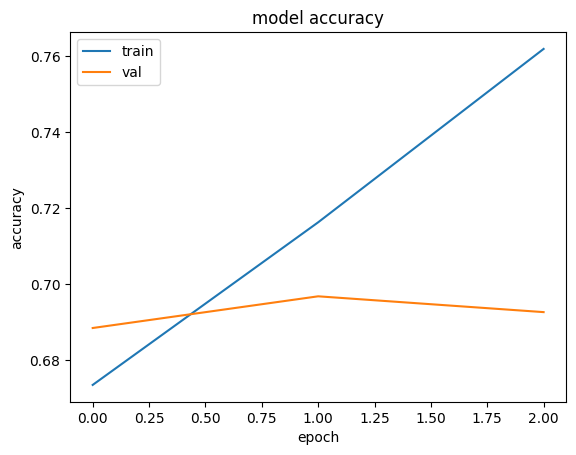

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##Plot of model loss vs epochs




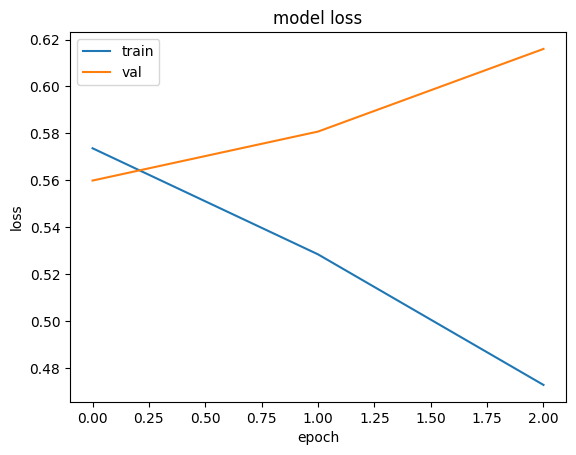

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Confusion matrix



In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, y_pred)

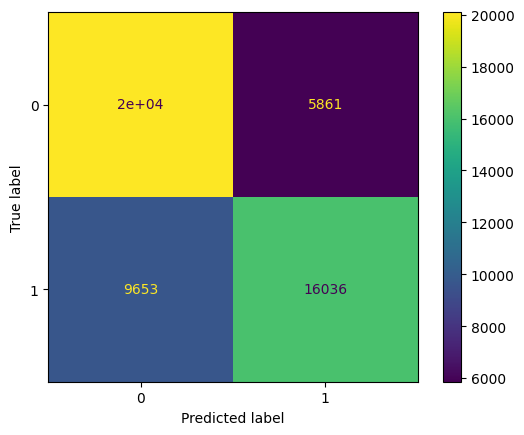

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()